## Gibbs sampler code

## Python Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

%matplotlib inline

## Data imports

## DEFINE THE PATH TO YOUR COURSE DIRECTORY

In [2]:
data_dir = "/Users/mniel/Courses/Algorithms_in_Bioinf/ipython/data/"

## Define run parameters

In [3]:
def initialize():

    T_i = 1.0
    T_f = 0.0001
    T_steps = 5
    T_delta = (T_f - T_i) / T_steps
    T = np.linspace(T_i,T_f,T_steps )
    
    iters_per_point = 6
    
    seed = 1
    # random seed for this run
    np.random.seed( seed )
    
    sequence_weighting = True
    
    beta = 50

    return T, iters_per_point, beta, sequence_weighting  

## Load data files

In [4]:
alphabet_file = data_dir + "Matrices/alphabet"
#alphabet_file = "https://raw.githubusercontent.com/brunoalvarez89/data/master/algorithms_in_bioinformatics/part_5/alphabet"

alphabet = np.loadtxt(alphabet_file, dtype=str)

#alphabet

bg_file = data_dir + "Matrices/bg.freq.fmt"
#bg_file = "https://raw.githubusercontent.com/brunoalvarez89/data/master/algorithms_in_bioinformatics/part_5/bg"

_bg = np.loadtxt(bg_file, dtype=float)

bg = {}
for i in range(0, len(alphabet)):
    bg[alphabet[i]] = _bg[i]

bg

blosum_file = data_dir + "Matrices//blosum62.freq_rownorm"
#blosum_file = "https://raw.githubusercontent.com/brunoalvarez89/data/master/algorithms_in_bioinformatics/part_5/blosum62.freq_rownorm"

_blosum62 = np.loadtxt(blosum_file, dtype=float).reshape((20, 20)).T

blosum62 = {}

for i, letter_1 in enumerate(alphabet):
    
    blosum62[letter_1] = {}

    for j, letter_2 in enumerate(alphabet):
        
        blosum62[letter_1][letter_2] = _blosum62[i, j]

#blosum62

## Calculate log-odd matrix from a given peptide core alignment

In [5]:
def initialize_matrix(core_len, alphabet):

    init_matrix = [0]*core_len

    for i in range(0, core_len):

        row = {}

        for letter in alphabet: 
            row[letter] = 0.0

        #fancy way:  row = dict( zip( alphabet, [0.0]*len(alphabet) ) )

        init_matrix[i] = row
        
    return init_matrix

def put_to_zero(matrix):
    
    for i in range(0, len(matrix)):

        for key in matrix[i].keys():
        
            matrix[i][key] = 0.0
    
    return matrix
            
def get_log_odds(peptides, alphabet, bg, scoring_scheme, core_len, c_matrix, f_matrix, g_matrix, p_matrix, w_matrix):

    # Amino Acid Count Matrix (c)

    c_matrix = put_to_zero(c_matrix)

    for position in range(0, core_len):

        # peptides has two elements; element[0] is the peptide sequence, element [1] is the core location
        for element in peptides:
            
            peptide = element[0]
            
            core_start = element[1]
            
            c_matrix[position][peptide[core_start+position]] += 1

            
    # Sequence Weighting
    weights = {}

    for element in peptides:

        peptide = element[0]
        core_start = element[1]
            
        # apply sequence weighting
        if sequence_weighting:

            w = 0.0
            neff = 0.0

            for position in range(0, core_len):

                r = 0

                for letter in alphabet:        

                    if c_matrix[position][letter] != 0:

                        r += 1

                s = c_matrix[position][peptide[core_start+position]]

                w += 1.0/(r * s)

                neff += r

            neff = neff / core_len

        # do not apply sequence weighting
        else:

            w = 1  

            neff = len(peptides)  


        weights[peptide] = w

    
    # Observed Frequencies Matrix (f)
    f_matrix = put_to_zero(f_matrix)

    for position in range(0, core_len):

        n = 0;

        for element in peptides:

            peptide = element[0]
            
            core_start = element[1]
              
            f_matrix[position][peptide[core_start+position]] += weights[peptide]

            n += weights[peptide]

        for letter in alphabet: 

            f_matrix[position][letter] = f_matrix[position][letter]/n

    
    # Pseudo Frequencies Matrix (g)
    g_matrix = put_to_zero(g_matrix)

    for position in range(0, core_len):

        for letter_1 in alphabet:
            
            for letter_2 in alphabet:

                 g_matrix[position][letter_1] += f_matrix[position][letter_2] * scoring_scheme[letter_1][letter_2]

                    
    # Combined Frequencies Matrix (p)

    alpha = neff - 1

    for position in range(0, core_len):

        for letter in alphabet:

            num = alpha*f_matrix[position][letter] + beta*g_matrix[position][letter]
            
            den = alpha + beta

            p_matrix[position][letter] = num / den
        

    # Log Odds Weight Matrix (w)
    for position in range(0, core_len):

        for letter in alphabet:

            if p_matrix[position][letter] != 0:
                
                w_matrix[position][letter] = np.log(p_matrix[position][letter]/bg[letter])/np.log(2)
    
    # Calculate the overall score of the peptides to the LO matrix
    _sum = 0
    for position in range(0, core_len):
        for letter in alphabet:
            _sum += f_matrix[position][letter] * w_matrix[position][letter]
    
    return w_matrix, _sum, p_matrix

## Score peptides to matrix

In [6]:
def score_peptide(peptide, core_start, core_len, matrix):
    acum = 0
    for i in range(0, core_len):
        acum += matrix[i][peptide[i+core_start]]
    return acum

## Read peptides

In [7]:
def load_peptide_data():
    
    peptides_file = data_dir + "Gibbs/DRB10401.lig"
    #peptides_file = "https://raw.githubusercontent.com/brunoalvarez89/data/master/algorithms_in_bioinformatics/part_5/DRB10401.lig"
    
    # Remove peptides shorter than core_len
    raw_peptides = np.loadtxt(peptides_file, dtype=str).tolist()

    # only keep peptides with length equal to or longer than core_len
    peptides = []
    for i in range(0, len(raw_peptides)):
        if len(raw_peptides[i]) >= core_len:          
            peptides.append(raw_peptides[i])
        else:
            print ("Peptide length too short discard", raw_peptides[i])
    
    peptides = sorted(peptides, key=len)
    min_pep_len = len(peptides[0])
    max_pep_len = len(peptides[-1])

    # random core start
    np.random.shuffle(peptides)
    cores_start = [0]*len(peptides)

    for i in range(0, len(cores_start)):

        if len(peptides[i]) != core_len:

            min_core_start = 0
            # Note bug in code, corrected to +1, 9/6/2021
            max_core_start = len(peptides[i]) - core_len + 1

            cores_start[i] = np.random.randint(min_core_start, max_core_start)

    peptides = list(zip(peptides, cores_start))

    return peptides, min_pep_len, core_len

## Print out w-matrix in Psi_blast format

In [8]:
def to_psi_blast(matrix):

    header = ["", "A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

    print('{:>4} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8}'.format(*header)) 

    letter_order = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

    for i, row in enumerate(matrix):

        scores = []

        scores.append(str(i+1) + " A")

        for letter in letter_order:

            score = row[letter]

            scores.append(round(score, 4))

        print('{:>4} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8}'.format(*scores)) 


## Main loop

In [ ]:
#core_len = min_pep_len
core_len = 9

# get temperature and iterations (Note moved up to before load_peptide_data())
T, iters_per_point, beta, sequence_weighting = initialize()

# get peptides
peptides, min_pep_len, core_len = load_peptide_data()

# Define number of iterations per temperature step
iters = len(peptides)*iters_per_point

# initialize matrices
c_matrix = initialize_matrix(core_len, alphabet)
f_matrix = initialize_matrix(core_len, alphabet)
g_matrix = initialize_matrix(core_len, alphabet)
p_matrix = initialize_matrix(core_len, alphabet)
w_matrix = initialize_matrix(core_len, alphabet)

# get initial log-odds matrix
log_odds_matrix, peptide_scores, _ = get_log_odds(peptides, alphabet, bg, blosum62, core_len, c_matrix, f_matrix, g_matrix, p_matrix, w_matrix)

# initial kld score
print( "Initial KLD score: " + str(peptide_scores))
kld = []
kld.append( peptide_scores )

# other stuff
t0 = time()
debug = False
#debug = True

for t in T:

    for i in range(0, iters):
            
        # extract peptide
        rand_index = np.random.randint(0,len(peptides)-1)
        peptide = peptides[rand_index][0]
        core_start_original = peptides[rand_index][1]

        if len(peptide) != core_len:
            
            # Bug in code, missing +1
            max_core_start = len(peptide) - core_len + 1

            # Maybe add check to sure core_start_shifted != core_start_original ?
            core_start_shifted = np.random.randint(0, max_core_start)
            while (core_start_shifted == core_start_original):
                #print( "Pep: " + peptide + "Shift org: " + str(core_start_original) + " new: " + str(core_start_shifted))
                core_start_shifted = np.random.randint(0, max_core_start)
                     
            # remove peptide from list
            peptides.remove(peptides[rand_index])

            # get base log_odds
            log_odds_matrix, peptide_scores, p_matrix = get_log_odds(peptides, alphabet, bg, blosum62, core_len, c_matrix, f_matrix, g_matrix, p_matrix, w_matrix)
                
            # score peptide against log_odds
            e_original = score_peptide(peptide, core_start_original, core_len, log_odds_matrix)
            if debug: print("Energy before shifting: " + str(e_original))

            # score shifted peptide against log_odds
            #e_shift = XX
            e_shift = score_peptide(peptide, core_start_shifted, core_len, log_odds_matrix)
            if debug: print("Energy after shifting: " + str(e_shift))

            # energy differential
            #de = XX
            de = e_shift - e_original
    
            # probability of accepting move
            if ( de > 0):
                p = 1
            else:
                #p = np.exp(XX/t)
                p = np.exp(de/t)
    
            # throw coin
            coin = np.random.uniform(0.0, 1.0, 1)[0]

            #if coin XX p:
            if coin < p:
                if debug: print("RNG < P, Move accepted")
                peptides.append((peptide, core_start_shifted))
                kld.append(peptide_scores)

            else:
                if debug: print("RNG >= P, Move rejected")
                peptides.append((peptide, core_start_original))      
                      
        else:
            if debug: print("Can't shift peptide, it is a " + str(core_len) + "mer")
              
    print( "KLD score t: " + str(t) + " KLD: " + str(peptide_scores))
    
t1 = time()

print("Time elapsed (m):", (t1-t0)/60)

Initial KLD score: 0.7135978121166894
KLD score t: 1.0 KLD: 1.8228288461717692
KLD score t: 0.7500249999999999 KLD: 2.505135360982662
KLD score t: 0.50005 KLD: 2.9944278964541615
KLD score t: 0.25007500000000005 KLD: 3.231365511557092


## Plot KLD curve

In [ ]:
x = np.arange(0,len(kld))
plt.plot(x,kld)
plt.show()

## Write out PSSM matrix

In [ ]:
to_psi_blast(log_odds_matrix)

## Scoring peptides to weight matrix

In [10]:
evaluation_file = data_dir + "Gibbs/DRB10401.eval"
#evaluation_file = "https://raw.githubusercontent.com/brunoalvarez89/data/master/algorithms_in_bioinformatics/part_5/DRB10401.eval"

evaluation = np.loadtxt(evaluation_file, dtype=str).reshape(-1,3)
evaluation_peptides_raw = evaluation[:, 0]
evaluation_targets_raw = evaluation[:, 1].astype(float)

# remove peptides shorter than core_len
evaluation_peptides = []
evaluation_targets = []
for i in range(0, len(evaluation_peptides_raw)):
    if len(evaluation_peptides_raw[i]) >= core_len:          
        evaluation_peptides.append(evaluation_peptides_raw[i])
        evaluation_targets.append(evaluation_targets_raw[i])
    else:
        print( "Peptide length too short discard", valuation_peptides_raw[i] )

#print(len(min(evaluation_peptides, key=len)))

corelen = 9
predictions = []

npeptides = len(evaluation_peptides)

#for peptide in evaluation_peptides:
for k in range(npeptides):
    peptide = evaluation_peptides[k]
    target = evaluation_targets[k]
    max_score = -99
    core_p1 = -9
    for i in range(0, len(peptide)-corelen+1):
        score = 0;
        for j in range(0, corelen):
            #score += XX
            score += log_odds_matrix[j][peptide[i+j]]
        if ( score > max_score):
            #max_score = XX
            #core_p1 = XX
            max_score = score
            core_p1 = i
    print( peptide, core_p1, peptide[core_p1:core_p1+corelen], max_score, target )
    predictions.append(max_score)

PRYVKQNTLKLATGM 1 RYVKQNTLK 6.148428627113578 0.340972
TLYLQMNSLRAEDTA 2 YLQMNSLRA 3.9319600216573574 1.0
YLQMNSLRAEDTAVY 0 YLQMNSLRA 3.9319600216573574 0.919907
NTLYLQMNSLRAEDT 3 YLQMNSLRA 3.9319600216573574 1.0
ESSFVMMSAPPAEYK 3 FVMMSAPPA 5.6097595487213505 0.375605
FVMMSAPPAEYKLQQ 0 FVMMSAPPA 5.6097595487213505 0.412954
SFVMMSAPPAEYKLQ 1 FVMMSAPPA 5.6097595487213505 0.415043
GKWYLKAMTADQEVPE 2 WYLKAMTAD 5.059825780214895 0.769569
LGASPYKLGPSPKAR 5 YKLGPSPKA 2.8662191147549048 0.833644
YKLGPSPKARSERPA 0 YKLGPSPKA 2.8662191147549048 0.574684
ERRNKYLEEHPSAGK 5 YLEEHPSAG 3.5684551787311234 0.360028
NKYLEEHPSAGKDPK 2 YLEEHPSAG 3.5684551787311234 0.433383
TVWAQSADFPQFKPE 2 WAQSADFPQ 5.207506190261995 0.799043
PVVHFFKNIVTPRTPPY 4 FFKNIVTPR 5.263763247852188 0.671995
DENPVVHFFKNIVTPRTPPP 7 FFKNIVTPR 5.263763247852188 0.770954
DFREFSRAKGLNQEI 1 FREFSRAKG 3.4749112099490445 0.555788
QEALEDFREFSRAKG 6 FREFSRAKG 3.4749112099490445 0.363799
IYKASPTLAFPAGVC 0 IYKASPTLA 3.896197018520043 0.640385


LHRVVLLESIAQFGD 3 VVLLESIAQ 1.4958943293955422 0.770464
LEAKATFYGSNPRGA 0 LEAKATFYG 2.1817688730204026 0.414328
LNTLVKQLSSNFGAI 4 VKQLSSNFG 0.9867222516982691 0.758614
REEHYIVLSSELRLS 4 YIVLSSELR 3.09790004192016 0.388118
AFLIGANYLGKPKEQ 1 FLIGANYLG 3.7234666389567472 0.74046
YEEFCDAVYENDKLK 6 AVYENDKLK 1.4270086128632578 0.389613
KISVQYNLSHSYAVD 0 KISVQYNLS 1.4043758257957983 0.726979
TRSAYERMCNILKGK 4 YERMCNILK 3.243891044087352 0.368456
RDGQLTIKAERTEQK 6 IKAERTEQK 1.9578554694644912 0.567104
TIKAERTEQKDFDGR 1 IKAERTEQK 1.9578554694644912 0.450574
YLGLLSQRTRDIYIS 2 GLLSQRTRD 0.8053657702473714 0.584784
PSPIGYLGLLSQRTR 5 YLGLLSQRT 0.673254132990454 0.763424
FTVQKGSDPKKLVLD 0 FTVQKGSDP 1.8351101673817198 0.34841
TFGAASNKAFAEGLS 1 FGAASNKAF 3.059256523681209 0.543811
FGSMPALTIACMTVQ 0 FGSMPALTI 1.3839814736068519 0.61646
KLNNQFGSMPALTIA 5 FGSMPALTI 1.3839814736068519 0.768912
QIYFESYVRPFVATT 2 YFESYVRPF 3.1039009248816103 0.472448
GFIGFCKSMGSKCVR 1 FIGFCKSMG 1.23492972410064 0.721142
SG

HKGIVIKSKKKGSTP 3 IVIKSKKKG 0.6212842671702918 0.428536
FNGGESKLKAEATTD 6 KLKAEATTD 1.8943453531369854 0.386568
VSLIAVIKGIINLYK 6 IKGIINLYK 1.4659422798233503 0.330782
VLRTKLMSTRRVLER 2 RTKLMSTRR 0.2394974641641315 0.391091
KSIIKARVVWKAIIE 2 IIKARVVWK 1.287140952606683 0.390587
GGVVQPGRSLRLSCA 2 VVQPGRSLR 0.07018405900243715 0.486945
SVGSLGRYKDEKDVT 0 SVGSLGRYK -0.43651540780427533 0.343024
QLIQLINVDEVNQIVTT 1 LIQLINVDE 0.9443111703453779 0.511102
LQLIQLINVDEVNQIVTTN 2 LIQLINVDE 0.9443111703453779 0.544326
DDDYGEPIIITSYLQ 6 PIIITSYLQ 0.15129931450622291 0.452955
LASSCQVAFSYFPPP 6 VAFSYFPPP 0.041087299570220615 0.315376
LPADLMIRIIAQGPK 6 IRIIAQGPK 1.8899473754177007 0.405288
IDQVTIAGAKLRSLN 3 VTIAGAKLR -0.21204473874223997 0.403124
MLFRILSLNLIKIK 2 FRILSLNLI 0.8279901164669752 0.620541
KCKYPEGTKVTFHVE 2 KYPEGTKVT 1.8141387781579024 0.312895
KAFAEGLSGEPKGGA 0 KAFAEGLSG 1.3970394314880057 0.383707
KSHFAIGLALYYPSA 3 FAIGLALYY 0.13763509125235462 0.493012
MGEAVQNTVEDLKLN 1 GEAVQNTVE 1.75504

PCC:  0.3574051595997995


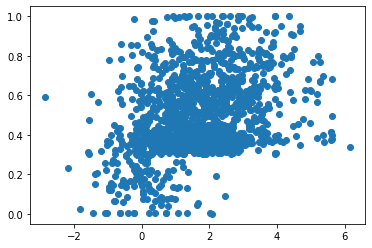

In [11]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

pcc = pearsonr(evaluation_targets, predictions)
print("PCC: ", pcc[0])

plt.scatter( predictions, evaluation_targets);